In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm

from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
  
plt.style.use('ggplot')

In [2]:
# os.makedirs('DataLagsPklNew', exist_ok=True)
# df = pd.DataFrame()
# for filename in tqdm(os.listdir('DataLags/')[:1]):
#     if '.csv' in filename:
#         data = pd.read_csv(f'DataLags/{filename}')
#         data.to_pickle(f'DataLagsPklNew/{filename.replace("csv", "pkl")}', protocol=2)
# #         df = pd.concat([df, data])

## Read data

In [4]:
N_READ_FILES = 10

df = pd.DataFrame()
for filename in tqdm(os.listdir('DataLagsPkl/')[:N_READ_FILES]):
    if '.pkl' in filename:
        data = pd.read_pickle(f'DataLagsPkl/{filename}')
        df = pd.concat([df, data])
        
df = df.reset_index(drop=True)

  0%|          | 0/10 [00:00<?, ?it/s]

In [5]:
print(df.shape)

(3041244, 140)


In [6]:
df_sample = df.copy()

## Merge locations

In [7]:
location_dict = pd.read_csv('LOCATION.csv', sep=';').rename(
    columns={
        'STORE_LOCATION_RK': 'store_location_rk',
        'STORE_LOCATION_LVL_RK3': 'city',
        'STORE_LOCATION_LVL_RK2': 'region'
    }
)

In [8]:
df_merged = df_sample.merge(location_dict[['store_location_rk', 'city', 'region']], how='left', on='store_location_rk')

In [9]:
assert df_merged['city'].isna().sum() == 0
assert df_merged['region'].isna().sum() == 0

## Clustering 

In [10]:
df_merged['period_start_dt'].max()

'2019-12-30'

In [11]:
train_split_date = '2019-10-01'

df_merged_train = df_merged[df_merged['period_start_dt'] <= train_split_date]
df_merged_test = df_merged[df_merged['period_start_dt'] > train_split_date]


print(f'Train contains {round(df_merged_train.shape[0] / df_merged.shape[0], 2) * 100}% of data')
print(f'Test contains {round(df_merged_test.shape[0] / df_merged.shape[0], 2) * 100}% of data')

Train contains 91.0% of data
Test contains 9.0% of data


In [12]:
## take top10 products by demand sum

# top_sum = df_merged.groupby('city')['demand'].mean()
# idx = top_sum.sort_values(ascending=False).head(10).index
# df_top = df[df['product_rk'].isin(idx)]
# top_sum

### ByCity

In [13]:
# df_merged = df_merged[df_merged['city'] != 39]

In [14]:
## calculate mean demand for every pair product-city

demand_top_sku_pivot = pd.pivot_table(df_merged_train.groupby(['product_rk', 'city'])['demand'].mean().reset_index(), 
                                      index='product_rk', values='demand', columns='city', fill_value=0).rename_axis(None, axis=1)
demand_top_sku_pivot.columns = demand_top_sku_pivot.columns.astype(str)
demand_top_sku_pivot.head()



,32,39,54,203,219
product_rk,,,,,
11389,0.000000,0.0,0.000000,1.095238,0.000000
11390,0.000000,0.0,0.000000,0.248875,0.000000
11391,0.000000,0.0,0.000000,0.267311,0.000000
11403,0.032787,0.0,0.000000,0.311703,0.107082
11404,0.000000,0.0,0.431372,0.904972,0.000000


In [15]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [16]:
agcl =  AgglomerativeClustering(distance_threshold=0, n_clusters=None)
agcl = agcl.fit(demand_top_sku_pivot)
# plot the top three levels of the dendrogram
# plot_dendrogram(agcl, truncate_mode="level", p=3)

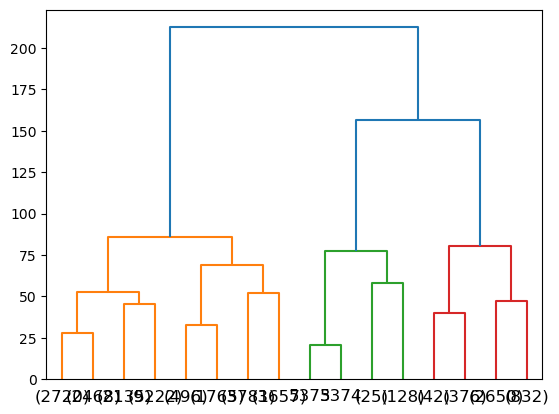

In [17]:
plot_dendrogram(agcl, truncate_mode="level", p=3)

**Silhouette score** aka Silhouette Coefficient is an evaluation metric that results in the range of -1 to 1. A score near 1 signifies the best importance that the data point is very compact within the cluster to which it belongs and far away from the other clusters. The score near -1 signifies the least or worst importance of the data point. A score near 0 signifies overlapping clusters. 

**Davies-Bouldin Index** score is defined as the average similarity measure of each cluster with its most similar cluster, where similarity is the ratio of within-cluster distances to between-cluster distances. Thus, clusters that are farther apart and less dispersed will result in a better score. The minimum score is 0, with lower values indicating better clustering.

In [18]:
results = pd.DataFrame({'n_clusters': [], 'ss': [], 'dbs': []})
n_clusters = [2, 3, 4, 5, 8, 10, 16, 20]


for i, n_cluster in tqdm(enumerate(n_clusters), total=len(n_clusters)):
    df_cluster = demand_top_sku_pivot.copy()
    agcl = AgglomerativeClustering(n_clusters=n_cluster)
    cluster_labels = agcl.fit_predict(df_cluster)

    df_cluster['label'] = cluster_labels
    ss = silhouette_score(df_cluster.drop('label', axis=1), df_cluster['label'])
    dbs = davies_bouldin_score(df_cluster.drop('label', axis=1), df_cluster['label'])
    
    results.loc[i] = [n_cluster, ss, dbs]

  0%|          | 0/8 [00:00<?, ?it/s]

In [19]:
results

,n_clusters,ss,dbs
0,2.0,0.549406,1.012326
1,3.0,0.518502,0.910494
2,4.0,0.240293,1.445352
3,5.0,0.249097,1.477751
4,8.0,0.253098,1.292019
5,10.0,0.164610,1.186719
6,16.0,0.220520,1.196692
7,20.0,0.236378,1.156275


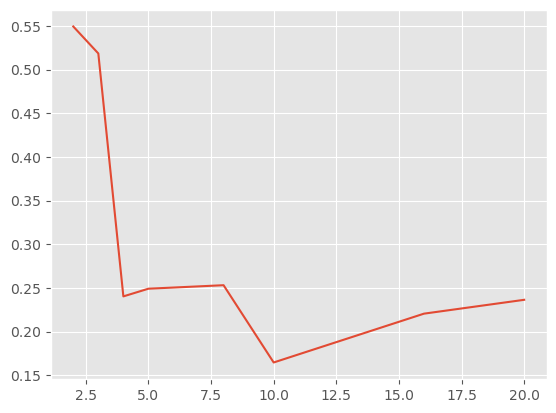

In [21]:
plt.plot(results['n_clusters'], results['ss'])

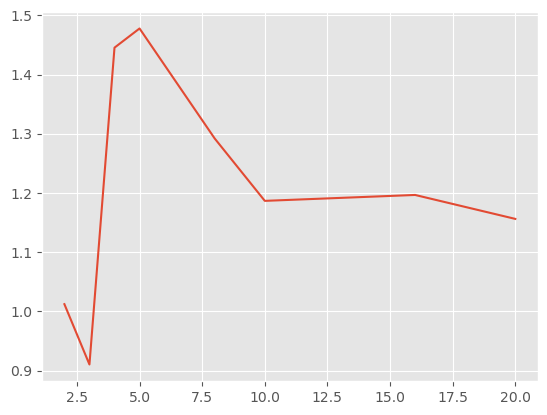

In [22]:
plt.plot(results['n_clusters'], results['dbs'])

In [23]:
## how to define number of clusters?

N_CLUSTERS = 3
agcl =  AgglomerativeClustering(n_clusters=N_CLUSTERS)
cluster_labels = agcl.fit_predict(demand_top_sku_pivot)

## add labels to dataset
demand_top_sku_pivot['label'] = cluster_labels
df_merged = df_merged.merge(demand_top_sku_pivot.reset_index()[['product_rk', 'label']], on='product_rk')
df_merged = df_merged.sort_values('period_start_dt')
df_merged.head()

,product_rk,store_location_rk,period_start_dt,demand,PROMO1_FLAG,PROMO2_FLAG,PRICE_REGULAR,PRICE_AFTER_DISC,NUM_CONSULTANT,AUTORIZATION_FLAG,...,demand_lag52_w112D_keyproduct_rk_store_location_rk_preagmean_agmedian_NO_FILTER_dynamic_rolling,demand_lag52_w224D_keyproduct_rk_store_location_rk_preagmean_agmean_NO_FILTER_dynamic_rolling,demand_lag52_w224D_keyproduct_rk_store_location_rk_preagmean_agmedian_NO_FILTER_dynamic_rolling,demand_lag52_w728D_keyproduct_rk_store_location_rk_preagmean_agmean_NO_FILTER_dynamic_rolling,demand_lag52_w728D_keyproduct_rk_store_location_rk_preagmean_agmedian_NO_FILTER_dynamic_rolling,demand_lag52_w1456D_keyproduct_rk_store_location_rk_preagmean_agmean_NO_FILTER_dynamic_rolling,demand_lag52_w1456D_keyproduct_rk_store_location_rk_preagmean_agmedian_NO_FILTER_dynamic_rolling,city,region,label
0,44467,1143,2016-12-26,1.344828,1.0,0.0,312.000000,271.285714,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39,10,0
1893357,61365,1034,2016-12-26,3.000000,1.0,0.0,338.428571,338.428571,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203,10,0
112547,50362,1143,2016-12-26,4.000000,1.0,0.0,49.000000,49.000000,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39,10,1
1893312,36360,1005,2016-12-26,1.000000,1.0,0.0,5899.000000,5899.000000,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,219,10,0
1893275,36360,1034,2016-12-26,1.060606,1.0,0.0,5899.000000,4002.892857,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203,10,0


In [27]:
df_merged['label'].value_counts(normalize=True)

0    0.639795
1    0.334039
2    0.026167
Name: label, dtype: float64

<Axes: xlabel='city'>

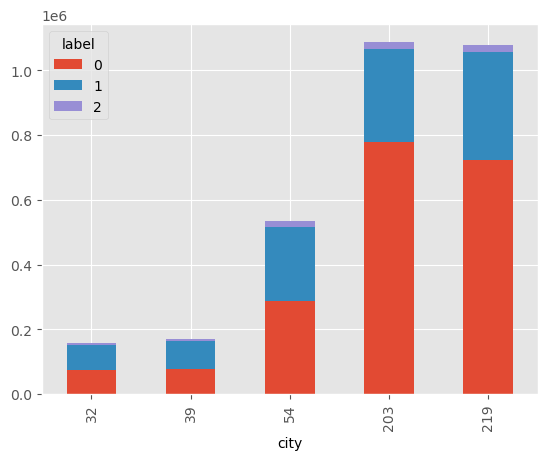

In [33]:
df_merged.groupby(['city', 'label'])['demand'].count().unstack().plot.bar(stacked=True)

## Predictions

### Splitting data

In [34]:
## now with labels

train_split_date = '2019-10-01'

df_merged_train = df_merged[df_merged['period_start_dt'] <= train_split_date]
df_merged_test = df_merged[df_merged['period_start_dt'] > train_split_date]


print(f'Train contains {round(df_merged_train.shape[0] / df_merged.shape[0], 2) * 100}% of data')
print(f'Test contains {round(df_merged_test.shape[0] / df_merged.shape[0], 2) * 100}% of data')

Train contains 92.0% of data
Test contains 8.0% of data


In [35]:
# df[df['period_start_dt'] > '2018-09-17'].groupby('period_start_dt')['label'].count().plot.bar(figsize=(20, 8))

In [36]:
# train_split_date = '2018-12-03'
# val_split_date = '2019-05-20'

# train = df_merged[df_merged['period_start_dt'] <= train_split_date]
# val = df_merged[(df_merged['period_start_dt'] > train_split_date) & (df_merged['period_start_dt'] <= val_split_date)]
# test = df_merged[df_merged['period_start_dt'] > val_split_date]


# print(f'Train contains {round(train.shape[0] / df_merged.shape[0], 2) * 100}% of data')
# print(f'Val contains {round(val.shape[0] / df_merged.shape[0], 2) * 100}% of data')
# print(f'Test contains {round(test.shape[0] / df_merged.shape[0], 2) * 100}% of data')

In [37]:
# main_cols = ['product_rk', 'city']
# lag_cols = train.columns[train.columns.str.contains('demand_')]

# train_cols = main_cols + list(lag_cols)

# X_train, y_train = train[train_cols].values, train['demand']
# X_val, y_val = val[train_cols].values, train['demand']
# X_test, y_test = test[train_cols].values, test['demand']

In [39]:
main_cols = ['product_rk', 'store_location_rk', 'PROMO1_FLAG', 'PROMO2_FLAG', 'city']
lag_cols = df_merged_train.columns[df_merged_train.columns.str.contains('demand_')]

train_cols = main_cols + list(lag_cols)

X_train, y_train = df_merged_train[train_cols].values, df_merged_train['demand']
X_test, y_test = df_merged_test[train_cols].values, df_merged_test['demand']

### No clustering

In [40]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

def get_best_params(X_train, y_train):

    model = CatBoostRegressor(iterations=100)

    grid = {
        'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10]
    }

    grid_search_result = model.grid_search(grid, X=X_train, y=y_train)
    
    return grid_search_result['params']

In [41]:
best_params = get_best_params(X_train, y_train)

cat = CatBoostRegressor(iterations=100, **best_params)
cat.fit(X_train, y_train)

0:	learn: 3.0025188	test: 2.9362518	best: 2.9362518 (0)	total: 284ms	remaining: 28.1s
1:	learn: 2.9781639	test: 2.9116085	best: 2.9116085 (1)	total: 533ms	remaining: 26.1s
2:	learn: 2.9549271	test: 2.8880819	best: 2.8880819 (2)	total: 735ms	remaining: 23.8s
3:	learn: 2.9330437	test: 2.8658716	best: 2.8658716 (3)	total: 955ms	remaining: 22.9s
4:	learn: 2.9120462	test: 2.8445903	best: 2.8445903 (4)	total: 1.17s	remaining: 22.2s
5:	learn: 2.8920510	test: 2.8244394	best: 2.8244394 (5)	total: 1.41s	remaining: 22.1s
6:	learn: 2.8730253	test: 2.8052039	best: 2.8052039 (6)	total: 1.63s	remaining: 21.7s
7:	learn: 2.8548401	test: 2.7868693	best: 2.7868693 (7)	total: 1.88s	remaining: 21.6s
8:	learn: 2.8374122	test: 2.7693064	best: 2.7693064 (8)	total: 2.08s	remaining: 21s
9:	learn: 2.8208250	test: 2.7525980	best: 2.7525980 (9)	total: 2.28s	remaining: 20.6s
10:	learn: 2.8051460	test: 2.7367827	best: 2.7367827 (10)	total: 2.52s	remaining: 20.4s
11:	learn: 2.7900274	test: 2.7213977	best: 2.7213977 (

94:	learn: 2.4756250	test: 2.4117615	best: 2.4117615 (94)	total: 22.3s	remaining: 1.17s
95:	learn: 2.4750624	test: 2.4114465	best: 2.4114465 (95)	total: 22.5s	remaining: 939ms
96:	learn: 2.4745553	test: 2.4110356	best: 2.4110356 (96)	total: 22.8s	remaining: 705ms
97:	learn: 2.4734781	test: 2.4106303	best: 2.4106303 (97)	total: 23s	remaining: 469ms
98:	learn: 2.4730062	test: 2.4101742	best: 2.4101742 (98)	total: 23.3s	remaining: 235ms
99:	learn: 2.4724428	test: 2.4096418	best: 2.4096418 (99)	total: 23.6s	remaining: 0us

bestTest = 2.409641788
bestIteration = 99

0:	loss: 2.4096418	best: 2.4096418 (0)	total: 28.6s	remaining: 2m 23s
0:	learn: 2.9448887	test: 2.8778396	best: 2.8778396 (0)	total: 299ms	remaining: 29.6s
1:	learn: 2.8747073	test: 2.8067456	best: 2.8067456 (1)	total: 673ms	remaining: 33s
2:	learn: 2.8149698	test: 2.7465026	best: 2.7465026 (2)	total: 941ms	remaining: 30.4s
3:	learn: 2.7656514	test: 2.6960868	best: 2.6960868 (3)	total: 1.24s	remaining: 29.8s
4:	learn: 2.7231512	

87:	learn: 2.4248214	test: 2.3762476	best: 2.3762476 (87)	total: 26.7s	remaining: 3.64s
88:	learn: 2.4244402	test: 2.3759600	best: 2.3759600 (88)	total: 27s	remaining: 3.34s
89:	learn: 2.4241040	test: 2.3758977	best: 2.3758977 (89)	total: 27.3s	remaining: 3.03s
90:	learn: 2.4233089	test: 2.3757885	best: 2.3757885 (90)	total: 27.5s	remaining: 2.72s
91:	learn: 2.4229876	test: 2.3755613	best: 2.3755613 (91)	total: 27.7s	remaining: 2.41s
92:	learn: 2.4225413	test: 2.3752830	best: 2.3752830 (92)	total: 27.9s	remaining: 2.1s
93:	learn: 2.4219022	test: 2.3748522	best: 2.3748522 (93)	total: 28.1s	remaining: 1.79s
94:	learn: 2.4215601	test: 2.3746407	best: 2.3746407 (94)	total: 28.4s	remaining: 1.5s
95:	learn: 2.4210523	test: 2.3744169	best: 2.3744169 (95)	total: 28.6s	remaining: 1.19s
96:	learn: 2.4204117	test: 2.3744158	best: 2.3744158 (96)	total: 28.8s	remaining: 892ms
97:	learn: 2.4198915	test: 2.3741871	best: 2.3741871 (97)	total: 29.1s	remaining: 594ms
98:	learn: 2.4194426	test: 2.3742749

80:	learn: 2.4555909	test: 2.4006598	best: 2.4006598 (80)	total: 25.6s	remaining: 6s
81:	learn: 2.4548958	test: 2.3999806	best: 2.3999806 (81)	total: 25.9s	remaining: 5.69s
82:	learn: 2.4540376	test: 2.3994384	best: 2.3994384 (82)	total: 26.2s	remaining: 5.37s
83:	learn: 2.4528824	test: 2.3988454	best: 2.3988454 (83)	total: 26.5s	remaining: 5.04s
84:	learn: 2.4519782	test: 2.3982829	best: 2.3982829 (84)	total: 26.8s	remaining: 4.72s
85:	learn: 2.4512807	test: 2.3977183	best: 2.3977183 (85)	total: 27.1s	remaining: 4.41s
86:	learn: 2.4504058	test: 2.3973173	best: 2.3973173 (86)	total: 27.3s	remaining: 4.08s
87:	learn: 2.4498626	test: 2.3968068	best: 2.3968068 (87)	total: 27.7s	remaining: 3.78s
88:	learn: 2.4491462	test: 2.3963088	best: 2.3963088 (88)	total: 28.1s	remaining: 3.47s
89:	learn: 2.4482368	test: 2.3956632	best: 2.3956632 (89)	total: 28.4s	remaining: 3.16s
90:	learn: 2.4475624	test: 2.3950444	best: 2.3950444 (90)	total: 28.8s	remaining: 2.85s
91:	learn: 2.4470233	test: 2.394437

73:	learn: 2.3930621	test: 2.3654064	best: 2.3654064 (73)	total: 25.3s	remaining: 8.87s
74:	learn: 2.3926636	test: 2.3652939	best: 2.3652939 (74)	total: 25.7s	remaining: 8.56s
75:	learn: 2.3912729	test: 2.3652113	best: 2.3652113 (75)	total: 26s	remaining: 8.22s
76:	learn: 2.3909361	test: 2.3648354	best: 2.3648354 (76)	total: 26.5s	remaining: 7.91s
77:	learn: 2.3895762	test: 2.3651055	best: 2.3648354 (76)	total: 26.9s	remaining: 7.59s
78:	learn: 2.3891143	test: 2.3648183	best: 2.3648183 (78)	total: 27.3s	remaining: 7.26s
79:	learn: 2.3888003	test: 2.3646098	best: 2.3646098 (79)	total: 27.9s	remaining: 6.98s
80:	learn: 2.3881990	test: 2.3643798	best: 2.3643798 (80)	total: 28.2s	remaining: 6.61s
81:	learn: 2.3874241	test: 2.3644933	best: 2.3643798 (80)	total: 28.4s	remaining: 6.24s
82:	learn: 2.3868042	test: 2.3643974	best: 2.3643798 (80)	total: 28.7s	remaining: 5.87s
83:	learn: 2.3858467	test: 2.3630450	best: 2.3630450 (83)	total: 28.9s	remaining: 5.5s
84:	learn: 2.3847906	test: 2.362723

65:	learn: 2.4254132	test: 2.3910123	best: 2.3910123 (65)	total: 2m 25s	remaining: 1m 15s
66:	learn: 2.4239354	test: 2.3898111	best: 2.3898111 (66)	total: 2m 27s	remaining: 1m 12s
67:	learn: 2.4225236	test: 2.3887889	best: 2.3887889 (67)	total: 2m 29s	remaining: 1m 10s
68:	learn: 2.4207535	test: 2.3877961	best: 2.3877961 (68)	total: 2m 31s	remaining: 1m 8s
69:	learn: 2.4190494	test: 2.3869660	best: 2.3869660 (69)	total: 2m 33s	remaining: 1m 5s
70:	learn: 2.4172418	test: 2.3861448	best: 2.3861448 (70)	total: 2m 34s	remaining: 1m 3s
71:	learn: 2.4159512	test: 2.3852236	best: 2.3852236 (71)	total: 2m 36s	remaining: 1m
72:	learn: 2.4146715	test: 2.3844881	best: 2.3844881 (72)	total: 2m 38s	remaining: 58.7s
73:	learn: 2.4132183	test: 2.3833875	best: 2.3833875 (73)	total: 2m 40s	remaining: 56.4s
74:	learn: 2.4117464	test: 2.3827477	best: 2.3827477 (74)	total: 2m 42s	remaining: 54.2s
75:	learn: 2.4103008	test: 2.3820294	best: 2.3820294 (75)	total: 2m 44s	remaining: 52s
76:	learn: 2.4092840	te

57:	learn: 2.3270469	test: 2.3538534	best: 2.3538534 (57)	total: 2m 1s	remaining: 1m 28s
58:	learn: 2.3257274	test: 2.3533332	best: 2.3533332 (58)	total: 2m 4s	remaining: 1m 26s
59:	learn: 2.3246330	test: 2.3528244	best: 2.3528244 (59)	total: 2m 6s	remaining: 1m 24s
60:	learn: 2.3226534	test: 2.3525211	best: 2.3525211 (60)	total: 2m 7s	remaining: 1m 21s
61:	learn: 2.3209163	test: 2.3524379	best: 2.3524379 (61)	total: 2m 9s	remaining: 1m 19s
62:	learn: 2.3192615	test: 2.3518442	best: 2.3518442 (62)	total: 2m 12s	remaining: 1m 17s
63:	learn: 2.3182783	test: 2.3514084	best: 2.3514084 (63)	total: 2m 14s	remaining: 1m 15s
64:	learn: 2.3158253	test: 2.3499427	best: 2.3499427 (64)	total: 2m 16s	remaining: 1m 13s
65:	learn: 2.3146442	test: 2.3495415	best: 2.3495415 (65)	total: 2m 19s	remaining: 1m 11s
66:	learn: 2.3141601	test: 2.3492603	best: 2.3492603 (66)	total: 2m 20s	remaining: 1m 9s
67:	learn: 2.3129637	test: 2.3485807	best: 2.3485807 (67)	total: 2m 23s	remaining: 1m 7s
68:	learn: 2.3094

48:	learn: 2.2926593	test: 2.4177580	best: 2.4177580 (48)	total: 1m 29s	remaining: 1m 33s
49:	learn: 2.2907899	test: 2.4179643	best: 2.4177580 (48)	total: 1m 31s	remaining: 1m 31s
50:	learn: 2.2894332	test: 2.4168251	best: 2.4168251 (50)	total: 1m 34s	remaining: 1m 30s
51:	learn: 2.2858767	test: 2.4176609	best: 2.4168251 (50)	total: 1m 36s	remaining: 1m 28s
52:	learn: 2.2846436	test: 2.4171175	best: 2.4168251 (50)	total: 1m 38s	remaining: 1m 27s
53:	learn: 2.2820594	test: 2.4176435	best: 2.4168251 (50)	total: 1m 41s	remaining: 1m 26s
54:	learn: 2.2803920	test: 2.4172791	best: 2.4168251 (50)	total: 1m 43s	remaining: 1m 24s
55:	learn: 2.2777381	test: 2.4170212	best: 2.4168251 (50)	total: 1m 44s	remaining: 1m 22s
56:	learn: 2.2751045	test: 2.4179525	best: 2.4168251 (50)	total: 1m 46s	remaining: 1m 20s
57:	learn: 2.2726214	test: 2.4187058	best: 2.4168251 (50)	total: 1m 47s	remaining: 1m 18s
58:	learn: 2.2703843	test: 2.4196221	best: 2.4168251 (50)	total: 1m 49s	remaining: 1m 16s
59:	learn:

40:	learn: 2.2068193	test: 2.6138446	best: 2.6132823 (39)	total: 1m 27s	remaining: 2m 5s
41:	learn: 2.2044087	test: 2.6131107	best: 2.6131107 (41)	total: 1m 29s	remaining: 2m 3s
42:	learn: 2.2020065	test: 2.6124514	best: 2.6124514 (42)	total: 1m 31s	remaining: 2m
43:	learn: 2.1994649	test: 2.6116635	best: 2.6116635 (43)	total: 1m 32s	remaining: 1m 58s
44:	learn: 2.1957871	test: 2.6115511	best: 2.6115511 (44)	total: 1m 34s	remaining: 1m 55s
45:	learn: 2.1944445	test: 2.6110055	best: 2.6110055 (45)	total: 1m 36s	remaining: 1m 53s
46:	learn: 2.1922420	test: 2.6107554	best: 2.6107554 (46)	total: 1m 37s	remaining: 1m 50s
47:	learn: 2.1882377	test: 2.6114017	best: 2.6107554 (46)	total: 1m 39s	remaining: 1m 48s
48:	learn: 2.1856891	test: 2.6110124	best: 2.6107554 (46)	total: 1m 41s	remaining: 1m 46s
49:	learn: 2.1834040	test: 2.6103059	best: 2.6103059 (49)	total: 1m 44s	remaining: 1m 44s
50:	learn: 2.1803866	test: 2.6106859	best: 2.6103059 (49)	total: 1m 46s	remaining: 1m 42s
51:	learn: 2.179

32:	learn: 2.4308447	test: 2.1909728	best: 2.1909728 (32)	total: 51.4s	remaining: 1m 44s
33:	learn: 2.4288489	test: 2.1902309	best: 2.1902309 (33)	total: 53s	remaining: 1m 42s
34:	learn: 2.4261440	test: 2.1907371	best: 2.1902309 (33)	total: 54.6s	remaining: 1m 41s
35:	learn: 2.4239367	test: 2.1903414	best: 2.1902309 (33)	total: 56s	remaining: 1m 39s
36:	learn: 2.4214339	test: 2.1901274	best: 2.1901274 (36)	total: 57.6s	remaining: 1m 38s
37:	learn: 2.4194118	test: 2.1897148	best: 2.1897148 (37)	total: 59.8s	remaining: 1m 37s
38:	learn: 2.4168202	test: 2.1890170	best: 2.1890170 (38)	total: 1m 1s	remaining: 1m 36s
39:	learn: 2.4142068	test: 2.1887523	best: 2.1887523 (39)	total: 1m 3s	remaining: 1m 34s
40:	learn: 2.4110644	test: 2.1881096	best: 2.1881096 (40)	total: 1m 5s	remaining: 1m 33s
41:	learn: 2.4088769	test: 2.1881504	best: 2.1881096 (40)	total: 1m 6s	remaining: 1m 32s
42:	learn: 2.4069622	test: 2.1872950	best: 2.1872950 (42)	total: 1m 8s	remaining: 1m 30s
43:	learn: 2.4030729	test

41:	learn: 2.3264235	total: 1m 31s	remaining: 2m 6s
42:	learn: 2.3250573	total: 1m 33s	remaining: 2m 4s
43:	learn: 2.3239396	total: 1m 35s	remaining: 2m 1s
44:	learn: 2.3218979	total: 1m 37s	remaining: 1m 59s
45:	learn: 2.3204286	total: 1m 39s	remaining: 1m 57s
46:	learn: 2.3174525	total: 1m 41s	remaining: 1m 54s
47:	learn: 2.3126406	total: 1m 44s	remaining: 1m 52s
48:	learn: 2.3102939	total: 1m 46s	remaining: 1m 50s
49:	learn: 2.3088435	total: 1m 48s	remaining: 1m 48s
50:	learn: 2.3072728	total: 1m 50s	remaining: 1m 46s
51:	learn: 2.3044401	total: 1m 52s	remaining: 1m 43s
52:	learn: 2.3035563	total: 1m 54s	remaining: 1m 41s
53:	learn: 2.3016228	total: 1m 56s	remaining: 1m 39s
54:	learn: 2.3003679	total: 2m 1s	remaining: 1m 39s
55:	learn: 2.2959841	total: 2m 3s	remaining: 1m 36s
56:	learn: 2.2917963	total: 2m 5s	remaining: 1m 34s
57:	learn: 2.2902465	total: 2m 7s	remaining: 1m 32s
58:	learn: 2.2886831	total: 2m 9s	remaining: 1m 30s
59:	learn: 2.2874413	total: 2m 12s	remaining: 1m 28s
6

In [43]:
preds = cat.predict(X_test)

In [44]:
mse = mean_squared_error(preds, y_test)
print('Error without clustering:', mse)

Error without clustering: 3.289056356768888


### With clustering

In [46]:
mse_sum = 0
main_cols = ['product_rk', 'store_location_rk', 'PROMO1_FLAG', 'PROMO2_FLAG', 'city']
lag_cols = df_merged_train.columns[df_merged_train.columns.str.contains('demand_')]

for label in df_merged_train['label'].unique():
    
    X_train, y_train = df_merged_train[df_merged_train['label'] == label][train_cols].values, df_merged_train[df_merged_train['label'] == label]['demand']
    X_test, y_test = df_merged_test[df_merged_test['label'] == label][train_cols].values, df_merged_test[df_merged_test['label'] == label]['demand']
    
    best_params = get_best_params(X_train, y_train)

    cat = CatBoostRegressor(iterations=100, **best_params)
    cat.fit(X_train, y_train)
    
    preds = cat.predict(X_test)
    
    mse_sum += mean_squared_error(preds, y_test) * X_test.shape[0]
    
    

0:	learn: 0.9767479	test: 0.9853438	best: 0.9853438 (0)	total: 600ms	remaining: 59.4s
1:	learn: 0.9630374	test: 0.9717123	best: 0.9717123 (1)	total: 819ms	remaining: 40.2s
2:	learn: 0.9499144	test: 0.9586661	best: 0.9586661 (2)	total: 1.03s	remaining: 33.2s
3:	learn: 0.9375189	test: 0.9463411	best: 0.9463411 (3)	total: 1.68s	remaining: 40.4s
4:	learn: 0.9255740	test: 0.9344570	best: 0.9344570 (4)	total: 1.89s	remaining: 35.9s
5:	learn: 0.9141780	test: 0.9231324	best: 0.9231324 (5)	total: 2.09s	remaining: 32.8s
6:	learn: 0.9032751	test: 0.9122976	best: 0.9122976 (6)	total: 2.31s	remaining: 30.7s
7:	learn: 0.8928661	test: 0.9019378	best: 0.9019378 (7)	total: 2.5s	remaining: 28.8s
8:	learn: 0.8829619	test: 0.8921007	best: 0.8921007 (8)	total: 2.73s	remaining: 27.6s
9:	learn: 0.8737858	test: 0.8829792	best: 0.8829792 (9)	total: 2.96s	remaining: 26.7s
10:	learn: 0.8646704	test: 0.8739117	best: 0.8739117 (10)	total: 3.28s	remaining: 26.5s
11:	learn: 0.8559885	test: 0.8652691	best: 0.8652691 

94:	learn: 0.6840569	test: 0.6936064	best: 0.6936064 (94)	total: 25.9s	remaining: 1.36s
95:	learn: 0.6838293	test: 0.6933762	best: 0.6933762 (95)	total: 26.1s	remaining: 1.09s
96:	learn: 0.6836189	test: 0.6931620	best: 0.6931620 (96)	total: 26.3s	remaining: 812ms
97:	learn: 0.6833503	test: 0.6928869	best: 0.6928869 (97)	total: 26.4s	remaining: 539ms
98:	learn: 0.6831421	test: 0.6926747	best: 0.6926747 (98)	total: 26.6s	remaining: 268ms
99:	learn: 0.6829583	test: 0.6924844	best: 0.6924844 (99)	total: 26.7s	remaining: 0us

bestTest = 0.6924843828
bestIteration = 99

0:	loss: 0.6924844	best: 0.6924844 (0)	total: 32.5s	remaining: 2m 42s
0:	learn: 0.9441963	test: 0.9529820	best: 0.9529820 (0)	total: 332ms	remaining: 32.9s
1:	learn: 0.9041138	test: 0.9131376	best: 0.9131376 (1)	total: 559ms	remaining: 27.4s
2:	learn: 0.8697267	test: 0.8789594	best: 0.8789594 (2)	total: 730ms	remaining: 23.6s
3:	learn: 0.8411714	test: 0.8505417	best: 0.8505417 (3)	total: 946ms	remaining: 22.7s
4:	learn: 0.817

87:	learn: 0.6691140	test: 0.6785855	best: 0.6785855 (87)	total: 15.1s	remaining: 2.06s
88:	learn: 0.6689713	test: 0.6784377	best: 0.6784377 (88)	total: 15.3s	remaining: 1.89s
89:	learn: 0.6688423	test: 0.6783284	best: 0.6783284 (89)	total: 15.5s	remaining: 1.72s
90:	learn: 0.6687181	test: 0.6782214	best: 0.6782214 (90)	total: 15.6s	remaining: 1.54s
91:	learn: 0.6685745	test: 0.6780738	best: 0.6780738 (91)	total: 15.8s	remaining: 1.38s
92:	learn: 0.6684449	test: 0.6779619	best: 0.6779619 (92)	total: 16s	remaining: 1.2s
93:	learn: 0.6683704	test: 0.6778913	best: 0.6778913 (93)	total: 16.1s	remaining: 1.03s
94:	learn: 0.6682560	test: 0.6777968	best: 0.6777968 (94)	total: 16.3s	remaining: 855ms
95:	learn: 0.6682082	test: 0.6777617	best: 0.6777617 (95)	total: 16.4s	remaining: 685ms
96:	learn: 0.6680607	test: 0.6776225	best: 0.6776225 (96)	total: 16.6s	remaining: 514ms
97:	learn: 0.6679323	test: 0.6775073	best: 0.6775073 (97)	total: 16.9s	remaining: 344ms
98:	learn: 0.6678367	test: 0.677418

80:	learn: 0.6807387	test: 0.6904776	best: 0.6904776 (80)	total: 30.3s	remaining: 7.1s
81:	learn: 0.6804011	test: 0.6901392	best: 0.6901392 (81)	total: 30.5s	remaining: 6.69s
82:	learn: 0.6800600	test: 0.6897914	best: 0.6897914 (82)	total: 30.7s	remaining: 6.29s
83:	learn: 0.6797287	test: 0.6894573	best: 0.6894573 (83)	total: 30.9s	remaining: 5.89s
84:	learn: 0.6794151	test: 0.6891368	best: 0.6891368 (84)	total: 31.1s	remaining: 5.49s
85:	learn: 0.6791244	test: 0.6888456	best: 0.6888456 (85)	total: 31.3s	remaining: 5.09s
86:	learn: 0.6788667	test: 0.6885784	best: 0.6885784 (86)	total: 31.5s	remaining: 4.71s
87:	learn: 0.6785915	test: 0.6883011	best: 0.6883011 (87)	total: 31.7s	remaining: 4.33s
88:	learn: 0.6783266	test: 0.6880383	best: 0.6880383 (88)	total: 31.9s	remaining: 3.94s
89:	learn: 0.6780617	test: 0.6877673	best: 0.6877673 (89)	total: 32.1s	remaining: 3.57s
90:	learn: 0.6777861	test: 0.6874932	best: 0.6874932 (90)	total: 32.4s	remaining: 3.21s
91:	learn: 0.6775221	test: 0.6872

73:	learn: 0.6641428	test: 0.6741364	best: 0.6741364 (73)	total: 17.2s	remaining: 6.03s
74:	learn: 0.6639841	test: 0.6739873	best: 0.6739873 (74)	total: 17.3s	remaining: 5.78s
75:	learn: 0.6638040	test: 0.6738122	best: 0.6738122 (75)	total: 17.6s	remaining: 5.55s
76:	learn: 0.6636848	test: 0.6737527	best: 0.6737527 (76)	total: 17.7s	remaining: 5.3s
77:	learn: 0.6634850	test: 0.6735596	best: 0.6735596 (77)	total: 17.9s	remaining: 5.06s
78:	learn: 0.6633833	test: 0.6734642	best: 0.6734642 (78)	total: 18.1s	remaining: 4.81s
79:	learn: 0.6632737	test: 0.6733641	best: 0.6733641 (79)	total: 18.4s	remaining: 4.59s
80:	learn: 0.6631553	test: 0.6732791	best: 0.6732791 (80)	total: 18.5s	remaining: 4.34s
81:	learn: 0.6630014	test: 0.6731752	best: 0.6731752 (81)	total: 18.8s	remaining: 4.12s
82:	learn: 0.6628948	test: 0.6730644	best: 0.6730644 (82)	total: 19s	remaining: 3.89s
83:	learn: 0.6627831	test: 0.6729998	best: 0.6729998 (83)	total: 19.2s	remaining: 3.65s
84:	learn: 0.6626565	test: 0.672946

65:	learn: 0.6780316	test: 0.6886479	best: 0.6886479 (65)	total: 1m 17s	remaining: 40s
66:	learn: 0.6774007	test: 0.6880257	best: 0.6880257 (66)	total: 1m 18s	remaining: 38.8s
67:	learn: 0.6767942	test: 0.6874482	best: 0.6874482 (67)	total: 1m 19s	remaining: 37.5s
68:	learn: 0.6762240	test: 0.6868986	best: 0.6868986 (68)	total: 1m 20s	remaining: 36.3s
69:	learn: 0.6756866	test: 0.6863811	best: 0.6863811 (69)	total: 1m 22s	remaining: 35.2s
70:	learn: 0.6751533	test: 0.6858669	best: 0.6858669 (70)	total: 1m 23s	remaining: 34s
71:	learn: 0.6746405	test: 0.6853740	best: 0.6853740 (71)	total: 1m 24s	remaining: 32.8s
72:	learn: 0.6741663	test: 0.6848992	best: 0.6848992 (72)	total: 1m 25s	remaining: 31.6s
73:	learn: 0.6737235	test: 0.6844486	best: 0.6844486 (73)	total: 1m 26s	remaining: 30.5s
74:	learn: 0.6732833	test: 0.6840158	best: 0.6840158 (74)	total: 1m 27s	remaining: 29.3s
75:	learn: 0.6728318	test: 0.6835874	best: 0.6835874 (75)	total: 1m 29s	remaining: 28.1s
76:	learn: 0.6724541	test

57:	learn: 0.6559589	test: 0.6688100	best: 0.6688100 (57)	total: 1m 26s	remaining: 1m 2s
58:	learn: 0.6557304	test: 0.6686660	best: 0.6686660 (58)	total: 1m 28s	remaining: 1m 1s
59:	learn: 0.6555632	test: 0.6685077	best: 0.6685077 (59)	total: 1m 29s	remaining: 59.8s
60:	learn: 0.6552946	test: 0.6683802	best: 0.6683802 (60)	total: 1m 30s	remaining: 58.2s
61:	learn: 0.6549934	test: 0.6681002	best: 0.6681002 (61)	total: 1m 32s	remaining: 56.6s
62:	learn: 0.6547391	test: 0.6680285	best: 0.6680285 (62)	total: 1m 33s	remaining: 55s
63:	learn: 0.6545125	test: 0.6679380	best: 0.6679380 (63)	total: 1m 35s	remaining: 53.5s
64:	learn: 0.6543017	test: 0.6678562	best: 0.6678562 (64)	total: 1m 36s	remaining: 51.9s
65:	learn: 0.6540762	test: 0.6678073	best: 0.6678073 (65)	total: 1m 38s	remaining: 50.5s
66:	learn: 0.6539130	test: 0.6676565	best: 0.6676565 (66)	total: 1m 39s	remaining: 48.8s
67:	learn: 0.6537216	test: 0.6675287	best: 0.6675287 (67)	total: 1m 40s	remaining: 47.2s
68:	learn: 0.6534635	te

48:	learn: 0.6592422	test: 0.6648876	best: 0.6648876 (48)	total: 54s	remaining: 56.2s
49:	learn: 0.6588946	test: 0.6647438	best: 0.6647438 (49)	total: 55s	remaining: 55s
50:	learn: 0.6586800	test: 0.6646444	best: 0.6646444 (50)	total: 55.9s	remaining: 53.7s
51:	learn: 0.6584204	test: 0.6645488	best: 0.6645488 (51)	total: 56.8s	remaining: 52.4s
52:	learn: 0.6579564	test: 0.6641468	best: 0.6641468 (52)	total: 57.7s	remaining: 51.2s
53:	learn: 0.6575778	test: 0.6639261	best: 0.6639261 (53)	total: 58.7s	remaining: 50s
54:	learn: 0.6571717	test: 0.6636321	best: 0.6636321 (54)	total: 59.7s	remaining: 48.8s
55:	learn: 0.6568466	test: 0.6635161	best: 0.6635161 (55)	total: 1m	remaining: 47.6s
56:	learn: 0.6566403	test: 0.6634587	best: 0.6634587 (56)	total: 1m 1s	remaining: 46.4s
57:	learn: 0.6564098	test: 0.6633313	best: 0.6633313 (57)	total: 1m 2s	remaining: 45.2s
58:	learn: 0.6561524	test: 0.6631006	best: 0.6631006 (58)	total: 1m 3s	remaining: 44.2s
59:	learn: 0.6558154	test: 0.6627721	best: 

41:	learn: 0.6646453	test: 0.6604996	best: 0.6604996 (41)	total: 52.8s	remaining: 1m 12s
42:	learn: 0.6643394	test: 0.6603388	best: 0.6603388 (42)	total: 53.9s	remaining: 1m 11s
43:	learn: 0.6640790	test: 0.6601375	best: 0.6601375 (43)	total: 55.5s	remaining: 1m 10s
44:	learn: 0.6636970	test: 0.6597864	best: 0.6597864 (44)	total: 56.9s	remaining: 1m 9s
45:	learn: 0.6633182	test: 0.6594539	best: 0.6594539 (45)	total: 57.8s	remaining: 1m 7s
46:	learn: 0.6629970	test: 0.6593058	best: 0.6593058 (46)	total: 58.6s	remaining: 1m 6s
47:	learn: 0.6625681	test: 0.6589179	best: 0.6589179 (47)	total: 59.6s	remaining: 1m 4s
48:	learn: 0.6623501	test: 0.6587382	best: 0.6587382 (48)	total: 1m	remaining: 1m 2s
49:	learn: 0.6620741	test: 0.6585120	best: 0.6585120 (49)	total: 1m 1s	remaining: 1m 1s
50:	learn: 0.6617829	test: 0.6583125	best: 0.6583125 (50)	total: 1m 2s	remaining: 59.8s
51:	learn: 0.6614527	test: 0.6580978	best: 0.6580978 (51)	total: 1m 3s	remaining: 58.4s
52:	learn: 0.6610510	test: 0.657

33:	learn: 0.6631786	test: 0.6717238	best: 0.6717238 (33)	total: 32s	remaining: 1m 2s
34:	learn: 0.6626205	test: 0.6713406	best: 0.6713406 (34)	total: 32.9s	remaining: 1m 1s
35:	learn: 0.6621687	test: 0.6709087	best: 0.6709087 (35)	total: 33.9s	remaining: 1m
36:	learn: 0.6616358	test: 0.6704197	best: 0.6704197 (36)	total: 34.8s	remaining: 59.3s
37:	learn: 0.6612300	test: 0.6701376	best: 0.6701376 (37)	total: 35.7s	remaining: 58.3s
38:	learn: 0.6609136	test: 0.6698439	best: 0.6698439 (38)	total: 36.6s	remaining: 57.2s
39:	learn: 0.6606082	test: 0.6696612	best: 0.6696612 (39)	total: 37.5s	remaining: 56.2s
40:	learn: 0.6602012	test: 0.6693458	best: 0.6693458 (40)	total: 38.4s	remaining: 55.3s
41:	learn: 0.6599023	test: 0.6690987	best: 0.6690987 (41)	total: 39.3s	remaining: 54.3s
42:	learn: 0.6595130	test: 0.6687365	best: 0.6687365 (42)	total: 40.3s	remaining: 53.4s
43:	learn: 0.6591590	test: 0.6684875	best: 0.6684875 (43)	total: 41.2s	remaining: 52.4s
44:	learn: 0.6588093	test: 0.6683912	

44:	learn: 0.6607592	total: 1m 4s	remaining: 1m 18s
45:	learn: 0.6604984	total: 1m 5s	remaining: 1m 16s
46:	learn: 0.6602366	total: 1m 6s	remaining: 1m 15s
47:	learn: 0.6599111	total: 1m 8s	remaining: 1m 13s
48:	learn: 0.6596149	total: 1m 9s	remaining: 1m 12s
49:	learn: 0.6592989	total: 1m 10s	remaining: 1m 10s
50:	learn: 0.6590409	total: 1m 12s	remaining: 1m 9s
51:	learn: 0.6587518	total: 1m 13s	remaining: 1m 8s
52:	learn: 0.6585390	total: 1m 15s	remaining: 1m 6s
53:	learn: 0.6583016	total: 1m 16s	remaining: 1m 5s
54:	learn: 0.6580608	total: 1m 17s	remaining: 1m 3s
55:	learn: 0.6578382	total: 1m 19s	remaining: 1m 2s
56:	learn: 0.6575891	total: 1m 20s	remaining: 1m
57:	learn: 0.6572982	total: 1m 22s	remaining: 59.4s
58:	learn: 0.6570808	total: 1m 23s	remaining: 57.9s
59:	learn: 0.6568893	total: 1m 24s	remaining: 56.5s
60:	learn: 0.6566880	total: 1m 26s	remaining: 55s
61:	learn: 0.6565264	total: 1m 27s	remaining: 53.6s
62:	learn: 0.6563356	total: 1m 28s	remaining: 52.2s
63:	learn: 0.656

63:	learn: 1.8021437	test: 1.8339048	best: 1.8339048 (63)	total: 5.23s	remaining: 2.94s
64:	learn: 1.8005404	test: 1.8323277	best: 1.8323277 (64)	total: 5.29s	remaining: 2.85s
65:	learn: 1.7990282	test: 1.8308325	best: 1.8308325 (65)	total: 5.35s	remaining: 2.76s
66:	learn: 1.7974945	test: 1.8292973	best: 1.8292973 (66)	total: 5.43s	remaining: 2.67s
67:	learn: 1.7960512	test: 1.8278390	best: 1.8278390 (67)	total: 5.51s	remaining: 2.59s
68:	learn: 1.7947102	test: 1.8264966	best: 1.8264966 (68)	total: 5.58s	remaining: 2.51s
69:	learn: 1.7934367	test: 1.8251892	best: 1.8251892 (69)	total: 5.66s	remaining: 2.42s
70:	learn: 1.7920953	test: 1.8238405	best: 1.8238405 (70)	total: 5.75s	remaining: 2.35s
71:	learn: 1.7908514	test: 1.8226333	best: 1.8226333 (71)	total: 5.83s	remaining: 2.27s
72:	learn: 1.7897147	test: 1.8214989	best: 1.8214989 (72)	total: 5.9s	remaining: 2.18s
73:	learn: 1.7885951	test: 1.8203903	best: 1.8203903 (73)	total: 5.98s	remaining: 2.1s
74:	learn: 1.7875901	test: 1.81936

57:	learn: 1.7498173	test: 1.7812304	best: 1.7812304 (57)	total: 4.59s	remaining: 3.32s
58:	learn: 1.7494158	test: 1.7808852	best: 1.7808852 (58)	total: 4.66s	remaining: 3.24s
59:	learn: 1.7489820	test: 1.7805079	best: 1.7805079 (59)	total: 4.75s	remaining: 3.17s
60:	learn: 1.7487155	test: 1.7802270	best: 1.7802270 (60)	total: 4.82s	remaining: 3.08s
61:	learn: 1.7481592	test: 1.7797096	best: 1.7797096 (61)	total: 4.9s	remaining: 3s
62:	learn: 1.7476737	test: 1.7792531	best: 1.7792531 (62)	total: 4.96s	remaining: 2.92s
63:	learn: 1.7471455	test: 1.7787045	best: 1.7787045 (63)	total: 5.06s	remaining: 2.84s
64:	learn: 1.7467600	test: 1.7783249	best: 1.7783249 (64)	total: 5.14s	remaining: 2.77s
65:	learn: 1.7464111	test: 1.7779864	best: 1.7779864 (65)	total: 5.2s	remaining: 2.68s
66:	learn: 1.7459314	test: 1.7775620	best: 1.7775620 (66)	total: 5.29s	remaining: 2.6s
67:	learn: 1.7456828	test: 1.7773431	best: 1.7773431 (67)	total: 5.35s	remaining: 2.52s
68:	learn: 1.7452338	test: 1.7769402	b

51:	learn: 1.8124641	test: 1.8447139	best: 1.8447139 (51)	total: 5.91s	remaining: 5.46s
52:	learn: 1.8096761	test: 1.8419713	best: 1.8419713 (52)	total: 6s	remaining: 5.32s
53:	learn: 1.8069710	test: 1.8392752	best: 1.8392752 (53)	total: 6.1s	remaining: 5.19s
54:	learn: 1.8044314	test: 1.8367612	best: 1.8367612 (54)	total: 6.2s	remaining: 5.07s
55:	learn: 1.8019320	test: 1.8342975	best: 1.8342975 (55)	total: 6.36s	remaining: 5s
56:	learn: 1.7996127	test: 1.8320147	best: 1.8320147 (56)	total: 6.45s	remaining: 4.86s
57:	learn: 1.7974344	test: 1.8298423	best: 1.8298423 (57)	total: 6.54s	remaining: 4.74s
58:	learn: 1.7952692	test: 1.8276823	best: 1.8276823 (58)	total: 6.66s	remaining: 4.63s
59:	learn: 1.7932339	test: 1.8256304	best: 1.8256304 (59)	total: 6.76s	remaining: 4.51s
60:	learn: 1.7912066	test: 1.8236194	best: 1.8236194 (60)	total: 6.88s	remaining: 4.4s
61:	learn: 1.7893592	test: 1.8217984	best: 1.8217984 (61)	total: 6.97s	remaining: 4.27s
62:	learn: 1.7876008	test: 1.8200388	best

44:	learn: 1.7415389	test: 1.7752748	best: 1.7752748 (44)	total: 4.87s	remaining: 5.95s
45:	learn: 1.7408835	test: 1.7747331	best: 1.7747331 (45)	total: 4.95s	remaining: 5.81s
46:	learn: 1.7400896	test: 1.7739534	best: 1.7739534 (46)	total: 5.08s	remaining: 5.72s
47:	learn: 1.7394703	test: 1.7732376	best: 1.7732376 (47)	total: 5.16s	remaining: 5.59s
48:	learn: 1.7387903	test: 1.7724393	best: 1.7724393 (48)	total: 5.25s	remaining: 5.46s
49:	learn: 1.7381022	test: 1.7719209	best: 1.7719209 (49)	total: 5.36s	remaining: 5.36s
50:	learn: 1.7376209	test: 1.7715456	best: 1.7715456 (50)	total: 5.46s	remaining: 5.24s
51:	learn: 1.7367254	test: 1.7706795	best: 1.7706795 (51)	total: 5.58s	remaining: 5.15s
52:	learn: 1.7362785	test: 1.7703549	best: 1.7703549 (52)	total: 5.67s	remaining: 5.03s
53:	learn: 1.7358367	test: 1.7700546	best: 1.7700546 (53)	total: 5.75s	remaining: 4.9s
54:	learn: 1.7352031	test: 1.7696059	best: 1.7696059 (54)	total: 5.88s	remaining: 4.81s
55:	learn: 1.7345971	test: 1.7689

37:	learn: 1.8528958	test: 1.8864871	best: 1.8864871 (37)	total: 23.1s	remaining: 37.7s
38:	learn: 1.8468516	test: 1.8805505	best: 1.8805505 (38)	total: 23.7s	remaining: 37s
39:	learn: 1.8413280	test: 1.8751140	best: 1.8751140 (39)	total: 24.2s	remaining: 36.4s
40:	learn: 1.8359022	test: 1.8697991	best: 1.8697991 (40)	total: 24.8s	remaining: 35.7s
41:	learn: 1.8309389	test: 1.8649429	best: 1.8649429 (41)	total: 25.4s	remaining: 35s
42:	learn: 1.8260648	test: 1.8601560	best: 1.8601560 (42)	total: 25.9s	remaining: 34.4s
43:	learn: 1.8214045	test: 1.8555982	best: 1.8555982 (43)	total: 26.5s	remaining: 33.8s
44:	learn: 1.8170924	test: 1.8514490	best: 1.8514490 (44)	total: 27.1s	remaining: 33.1s
45:	learn: 1.8129191	test: 1.8473879	best: 1.8473879 (45)	total: 27.7s	remaining: 32.5s
46:	learn: 1.8087794	test: 1.8434016	best: 1.8434016 (46)	total: 28.4s	remaining: 32s
47:	learn: 1.8051832	test: 1.8399241	best: 1.8399241 (47)	total: 29s	remaining: 31.4s
48:	learn: 1.8015737	test: 1.8364193	bes

30:	learn: 1.7270640	test: 1.7670393	best: 1.7670393 (30)	total: 19.4s	remaining: 43.3s
31:	learn: 1.7256978	test: 1.7660127	best: 1.7660127 (31)	total: 20.1s	remaining: 42.8s
32:	learn: 1.7241113	test: 1.7645494	best: 1.7645494 (32)	total: 20.8s	remaining: 42.2s
33:	learn: 1.7225086	test: 1.7632385	best: 1.7632385 (33)	total: 21.5s	remaining: 41.8s
34:	learn: 1.7210428	test: 1.7622967	best: 1.7622967 (34)	total: 22.2s	remaining: 41.2s
35:	learn: 1.7198277	test: 1.7615082	best: 1.7615082 (35)	total: 22.8s	remaining: 40.5s
36:	learn: 1.7184158	test: 1.7602197	best: 1.7602197 (36)	total: 23.4s	remaining: 39.8s
37:	learn: 1.7174938	test: 1.7595262	best: 1.7595262 (37)	total: 23.9s	remaining: 39.1s
38:	learn: 1.7163808	test: 1.7588320	best: 1.7588320 (38)	total: 24.5s	remaining: 38.3s
39:	learn: 1.7151620	test: 1.7580392	best: 1.7580392 (39)	total: 25.2s	remaining: 37.8s
40:	learn: 1.7142002	test: 1.7572177	best: 1.7572177 (40)	total: 25.7s	remaining: 37s
41:	learn: 1.7133593	test: 1.75674

22:	learn: 1.7484002	test: 1.7685732	best: 1.7685732 (22)	total: 12.1s	remaining: 40.7s
23:	learn: 1.7447669	test: 1.7652994	best: 1.7652994 (23)	total: 12.8s	remaining: 40.4s
24:	learn: 1.7421201	test: 1.7629509	best: 1.7629509 (24)	total: 13.3s	remaining: 39.9s
25:	learn: 1.7393727	test: 1.7612013	best: 1.7612013 (25)	total: 13.8s	remaining: 39.3s
26:	learn: 1.7374058	test: 1.7596494	best: 1.7596494 (26)	total: 14.3s	remaining: 38.7s
27:	learn: 1.7354426	test: 1.7584090	best: 1.7584090 (27)	total: 14.8s	remaining: 38s
28:	learn: 1.7331253	test: 1.7565321	best: 1.7565321 (28)	total: 15.4s	remaining: 37.8s
29:	learn: 1.7314118	test: 1.7552572	best: 1.7552572 (29)	total: 16s	remaining: 37.3s
30:	learn: 1.7297621	test: 1.7542982	best: 1.7542982 (30)	total: 16.5s	remaining: 36.7s
31:	learn: 1.7282951	test: 1.7533269	best: 1.7533269 (31)	total: 17s	remaining: 36.1s
32:	learn: 1.7267834	test: 1.7523226	best: 1.7523226 (32)	total: 17.5s	remaining: 35.5s
33:	learn: 1.7256087	test: 1.7516808	b

15:	learn: 1.8088700	test: 1.7586729	best: 1.7586729 (15)	total: 8.29s	remaining: 43.5s
16:	learn: 1.7999866	test: 1.7501415	best: 1.7501415 (16)	total: 9.02s	remaining: 44s
17:	learn: 1.7934187	test: 1.7439402	best: 1.7439402 (17)	total: 9.56s	remaining: 43.5s
18:	learn: 1.7875415	test: 1.7384357	best: 1.7384357 (18)	total: 10.1s	remaining: 43.2s
19:	learn: 1.7821017	test: 1.7336908	best: 1.7336908 (19)	total: 10.7s	remaining: 42.7s
20:	learn: 1.7767854	test: 1.7286753	best: 1.7286753 (20)	total: 11.5s	remaining: 43.2s
21:	learn: 1.7727289	test: 1.7249326	best: 1.7249326 (21)	total: 12s	remaining: 42.7s
22:	learn: 1.7693531	test: 1.7220961	best: 1.7220961 (22)	total: 12.7s	remaining: 42.5s
23:	learn: 1.7660949	test: 1.7191282	best: 1.7191282 (23)	total: 13.2s	remaining: 42s
24:	learn: 1.7635966	test: 1.7171985	best: 1.7171985 (24)	total: 13.8s	remaining: 41.5s
25:	learn: 1.7608565	test: 1.7150480	best: 1.7150480 (25)	total: 17.9s	remaining: 50.9s
26:	learn: 1.7581897	test: 1.7128167	b

8:	learn: 1.8985804	test: 1.9434821	best: 1.9434821 (8)	total: 4.75s	remaining: 48s
9:	learn: 1.8706452	test: 1.9157336	best: 1.9157336 (9)	total: 5.31s	remaining: 47.8s
10:	learn: 1.8478587	test: 1.8931087	best: 1.8931087 (10)	total: 5.84s	remaining: 47.3s
11:	learn: 1.8285522	test: 1.8741130	best: 1.8741130 (11)	total: 6.35s	remaining: 46.6s
12:	learn: 1.8124675	test: 1.8583001	best: 1.8583001 (12)	total: 6.96s	remaining: 46.6s
13:	learn: 1.7992332	test: 1.8453902	best: 1.8453902 (13)	total: 7.46s	remaining: 45.8s
14:	learn: 1.7873962	test: 1.8339851	best: 1.8339851 (14)	total: 7.98s	remaining: 45.2s
15:	learn: 1.7775873	test: 1.8242292	best: 1.8242292 (15)	total: 8.48s	remaining: 44.5s
16:	learn: 1.7690239	test: 1.8158180	best: 1.8158180 (16)	total: 9s	remaining: 43.9s
17:	learn: 1.7622499	test: 1.8091450	best: 1.8091450 (17)	total: 9.52s	remaining: 43.3s
18:	learn: 1.7560456	test: 1.8033376	best: 1.8033376 (18)	total: 10.1s	remaining: 42.9s
19:	learn: 1.7508474	test: 1.7983726	best

2:	learn: 1.8825488	total: 2.19s	remaining: 1m 10s
3:	learn: 1.8623092	total: 2.94s	remaining: 1m 10s
4:	learn: 1.8454481	total: 3.66s	remaining: 1m 9s
5:	learn: 1.8311252	total: 4.38s	remaining: 1m 8s
6:	learn: 1.8188905	total: 5.08s	remaining: 1m 7s
7:	learn: 1.8081600	total: 5.91s	remaining: 1m 7s
8:	learn: 1.7991726	total: 6.73s	remaining: 1m 8s
9:	learn: 1.7916850	total: 7.41s	remaining: 1m 6s
10:	learn: 1.7844594	total: 8.11s	remaining: 1m 5s
11:	learn: 1.7791474	total: 8.8s	remaining: 1m 4s
12:	learn: 1.7740373	total: 9.56s	remaining: 1m 3s
13:	learn: 1.7693970	total: 10.3s	remaining: 1m 3s
14:	learn: 1.7644006	total: 11.1s	remaining: 1m 2s
15:	learn: 1.7605200	total: 11.9s	remaining: 1m 2s
16:	learn: 1.7568166	total: 12.8s	remaining: 1m 2s
17:	learn: 1.7539354	total: 13.7s	remaining: 1m 2s
18:	learn: 1.7514387	total: 14.4s	remaining: 1m 1s
19:	learn: 1.7485654	total: 15.1s	remaining: 1m
20:	learn: 1.7464868	total: 15.8s	remaining: 59.6s
21:	learn: 1.7439199	total: 16.8s	remaini

41:	learn: 12.6625894	test: 14.2327242	best: 14.2327242 (41)	total: 438ms	remaining: 605ms
42:	learn: 12.6339293	test: 14.2201570	best: 14.2201570 (42)	total: 450ms	remaining: 596ms
43:	learn: 12.6042695	test: 14.2131537	best: 14.2131537 (43)	total: 459ms	remaining: 584ms
44:	learn: 12.5802503	test: 14.1994653	best: 14.1994653 (44)	total: 468ms	remaining: 572ms
45:	learn: 12.5573941	test: 14.1863156	best: 14.1863156 (45)	total: 478ms	remaining: 561ms
46:	learn: 12.5339355	test: 14.1794368	best: 14.1794368 (46)	total: 485ms	remaining: 547ms
47:	learn: 12.5133688	test: 14.1682492	best: 14.1682492 (47)	total: 493ms	remaining: 534ms
48:	learn: 12.4898296	test: 14.1612444	best: 14.1612444 (48)	total: 501ms	remaining: 522ms
49:	learn: 12.4606219	test: 14.1550562	best: 14.1550562 (49)	total: 511ms	remaining: 511ms
50:	learn: 12.4430942	test: 14.1434873	best: 14.1434873 (50)	total: 519ms	remaining: 498ms
51:	learn: 12.4267732	test: 14.1342665	best: 14.1342665 (51)	total: 525ms	remaining: 485ms

38:	learn: 11.4916640	test: 13.9929733	best: 13.9831015 (35)	total: 346ms	remaining: 541ms
39:	learn: 11.4764707	test: 13.9850009	best: 13.9831015 (35)	total: 359ms	remaining: 539ms
40:	learn: 11.4585989	test: 13.9890151	best: 13.9831015 (35)	total: 371ms	remaining: 534ms
41:	learn: 11.4480341	test: 13.9853919	best: 13.9831015 (35)	total: 381ms	remaining: 526ms
42:	learn: 11.4195350	test: 13.9754960	best: 13.9754960 (42)	total: 390ms	remaining: 517ms
43:	learn: 11.4028494	test: 13.9566289	best: 13.9566289 (43)	total: 401ms	remaining: 511ms
44:	learn: 11.3873298	test: 13.9547238	best: 13.9547238 (44)	total: 412ms	remaining: 504ms
45:	learn: 11.3535223	test: 13.9608564	best: 13.9547238 (44)	total: 423ms	remaining: 496ms
46:	learn: 11.3274199	test: 13.9700732	best: 13.9547238 (44)	total: 433ms	remaining: 488ms
47:	learn: 11.3207907	test: 13.9684039	best: 13.9547238 (44)	total: 443ms	remaining: 480ms
48:	learn: 11.2947779	test: 13.9673747	best: 13.9547238 (44)	total: 451ms	remaining: 469ms

28:	learn: 12.8593236	test: 14.4664908	best: 14.4664908 (28)	total: 456ms	remaining: 1.12s
29:	learn: 12.8111333	test: 14.4415305	best: 14.4415305 (29)	total: 475ms	remaining: 1.11s
30:	learn: 12.7645096	test: 14.4138557	best: 14.4138557 (30)	total: 490ms	remaining: 1.09s
31:	learn: 12.7133645	test: 14.3913727	best: 14.3913727 (31)	total: 505ms	remaining: 1.07s
32:	learn: 12.6698294	test: 14.3676238	best: 14.3676238 (32)	total: 519ms	remaining: 1.05s
33:	learn: 12.6297234	test: 14.3432919	best: 14.3432919 (33)	total: 533ms	remaining: 1.03s
34:	learn: 12.5887048	test: 14.2996099	best: 14.2996099 (34)	total: 548ms	remaining: 1.02s
35:	learn: 12.5519982	test: 14.2785726	best: 14.2785726 (35)	total: 562ms	remaining: 998ms
36:	learn: 12.5176575	test: 14.2572831	best: 14.2572831 (36)	total: 576ms	remaining: 981ms
37:	learn: 12.4785421	test: 14.2404945	best: 14.2404945 (37)	total: 592ms	remaining: 966ms
38:	learn: 12.4334999	test: 14.2167025	best: 14.2167025 (38)	total: 606ms	remaining: 948ms

28:	learn: 11.2551598	test: 14.0822939	best: 14.0822939 (28)	total: 471ms	remaining: 1.15s
29:	learn: 11.2091847	test: 14.0793625	best: 14.0793625 (29)	total: 489ms	remaining: 1.14s
30:	learn: 11.1793727	test: 14.0765081	best: 14.0765081 (30)	total: 509ms	remaining: 1.13s
31:	learn: 11.1263525	test: 14.0606499	best: 14.0606499 (31)	total: 525ms	remaining: 1.12s
32:	learn: 11.0852135	test: 14.0620215	best: 14.0606499 (31)	total: 539ms	remaining: 1.09s
33:	learn: 11.0490244	test: 14.0645226	best: 14.0606499 (31)	total: 558ms	remaining: 1.08s
34:	learn: 11.0117953	test: 14.0597997	best: 14.0597997 (34)	total: 577ms	remaining: 1.07s
35:	learn: 10.9910212	test: 14.0515280	best: 14.0515280 (35)	total: 598ms	remaining: 1.06s
36:	learn: 10.9577341	test: 14.0451297	best: 14.0451297 (36)	total: 613ms	remaining: 1.04s
37:	learn: 10.9218852	test: 14.0609535	best: 14.0451297 (36)	total: 626ms	remaining: 1.02s
38:	learn: 10.8875364	test: 14.0533373	best: 14.0451297 (36)	total: 640ms	remaining: 1s
39

18:	learn: 13.1894328	test: 14.8129514	best: 14.8129514 (18)	total: 3s	remaining: 12.8s
19:	learn: 13.0979766	test: 14.7763977	best: 14.7763977 (19)	total: 3.15s	remaining: 12.6s
20:	learn: 13.0143598	test: 14.7396598	best: 14.7396598 (20)	total: 3.31s	remaining: 12.4s
21:	learn: 12.9431910	test: 14.7000095	best: 14.7000095 (21)	total: 3.46s	remaining: 12.3s
22:	learn: 12.8669219	test: 14.6688873	best: 14.6688873 (22)	total: 3.61s	remaining: 12.1s
23:	learn: 12.7849795	test: 14.6412801	best: 14.6412801 (23)	total: 3.76s	remaining: 11.9s
24:	learn: 12.7186224	test: 14.6073681	best: 14.6073681 (24)	total: 3.92s	remaining: 11.8s
25:	learn: 12.6492919	test: 14.5735705	best: 14.5735705 (25)	total: 4.07s	remaining: 11.6s
26:	learn: 12.5848668	test: 14.5519616	best: 14.5519616 (26)	total: 4.23s	remaining: 11.4s
27:	learn: 12.5225598	test: 14.5254830	best: 14.5254830 (27)	total: 4.38s	remaining: 11.3s
28:	learn: 12.4578016	test: 14.4897306	best: 14.4897306 (28)	total: 4.54s	remaining: 11.1s
29

8:	learn: 12.3186380	test: 14.3751516	best: 14.3751516 (8)	total: 1.38s	remaining: 13.9s
9:	learn: 12.1286304	test: 14.2866356	best: 14.2866356 (9)	total: 1.52s	remaining: 13.7s
10:	learn: 11.9588897	test: 14.2358368	best: 14.2358368 (10)	total: 1.68s	remaining: 13.6s
11:	learn: 11.8034695	test: 14.1945902	best: 14.1945902 (11)	total: 1.83s	remaining: 13.4s
12:	learn: 11.6632255	test: 14.1780793	best: 14.1780793 (12)	total: 1.99s	remaining: 13.3s
13:	learn: 11.5231756	test: 14.1013317	best: 14.1013317 (13)	total: 2.14s	remaining: 13.1s
14:	learn: 11.4037798	test: 14.0739666	best: 14.0739666 (14)	total: 2.29s	remaining: 13s
15:	learn: 11.3223240	test: 14.0447361	best: 14.0447361 (15)	total: 2.44s	remaining: 12.8s
16:	learn: 11.2165195	test: 14.0199561	best: 14.0199561 (16)	total: 2.6s	remaining: 12.7s
17:	learn: 11.1161624	test: 14.0073589	best: 14.0073589 (17)	total: 2.75s	remaining: 12.5s
18:	learn: 11.0267086	test: 13.9960522	best: 13.9960522 (18)	total: 2.91s	remaining: 12.4s
19:	le

6:	learn: 13.3955988	test: 14.1709558	best: 14.1709558 (6)	total: 50.1ms	remaining: 666ms
7:	learn: 13.2227471	test: 14.0184804	best: 14.0184804 (7)	total: 60.6ms	remaining: 697ms
8:	learn: 13.0827940	test: 13.9347645	best: 13.9347645 (8)	total: 66.7ms	remaining: 675ms
9:	learn: 12.9552685	test: 13.8516746	best: 13.8516746 (9)	total: 73ms	remaining: 657ms
10:	learn: 12.8586364	test: 13.7776573	best: 13.7776573 (10)	total: 80.3ms	remaining: 650ms
11:	learn: 12.7568707	test: 13.6909527	best: 13.6909527 (11)	total: 87.4ms	remaining: 641ms
12:	learn: 12.6681427	test: 13.6182381	best: 13.6182381 (12)	total: 94.3ms	remaining: 631ms
13:	learn: 12.5827377	test: 13.5801061	best: 13.5801061 (13)	total: 100ms	remaining: 616ms
14:	learn: 12.5038691	test: 13.5567369	best: 13.5567369 (14)	total: 106ms	remaining: 602ms
15:	learn: 12.4211670	test: 13.5299139	best: 13.5299139 (15)	total: 112ms	remaining: 589ms
16:	learn: 12.3700826	test: 13.4904771	best: 13.4904771 (16)	total: 119ms	remaining: 582ms
17

0:	learn: 15.6268376	test: 14.2936848	best: 14.2936848 (0)	total: 12.8ms	remaining: 1.27s
1:	learn: 15.1966513	test: 13.9634035	best: 13.9634035 (1)	total: 19.1ms	remaining: 938ms
2:	learn: 14.8955071	test: 13.6597411	best: 13.6597411 (2)	total: 27.5ms	remaining: 890ms
3:	learn: 14.6216951	test: 13.4162943	best: 13.4162943 (3)	total: 34ms	remaining: 817ms
4:	learn: 14.3977395	test: 13.2091797	best: 13.2091797 (4)	total: 41.5ms	remaining: 788ms
5:	learn: 14.1957228	test: 13.0463475	best: 13.0463475 (5)	total: 47.3ms	remaining: 740ms
6:	learn: 13.9502930	test: 12.9444526	best: 12.9444526 (6)	total: 53.3ms	remaining: 709ms
7:	learn: 13.7277395	test: 12.8505598	best: 12.8505598 (7)	total: 59.2ms	remaining: 681ms
8:	learn: 13.5350660	test: 12.7909231	best: 12.7909231 (8)	total: 65.3ms	remaining: 661ms
9:	learn: 13.3891613	test: 12.6874474	best: 12.6874474 (9)	total: 71.6ms	remaining: 644ms
10:	learn: 13.2300554	test: 12.6414051	best: 12.6414051 (10)	total: 80.6ms	remaining: 652ms
11:	learn:

0:	learn: 14.8769045	test: 15.8551917	best: 15.8551917 (0)	total: 6.96ms	remaining: 689ms
1:	learn: 14.4825561	test: 15.4972402	best: 15.4972402 (1)	total: 15.1ms	remaining: 739ms
2:	learn: 14.1450175	test: 15.2080722	best: 15.2080722 (2)	total: 21.5ms	remaining: 696ms
3:	learn: 13.8596750	test: 14.9459657	best: 14.9459657 (3)	total: 30.9ms	remaining: 742ms
4:	learn: 13.6125715	test: 14.7329441	best: 14.7329441 (4)	total: 39.2ms	remaining: 745ms
5:	learn: 13.4032609	test: 14.5339556	best: 14.5339556 (5)	total: 49.9ms	remaining: 782ms
6:	learn: 13.2288200	test: 14.3765342	best: 14.3765342 (6)	total: 60.4ms	remaining: 803ms
7:	learn: 13.0737352	test: 14.2375096	best: 14.2375096 (7)	total: 70.5ms	remaining: 810ms
8:	learn: 12.9545776	test: 14.1341124	best: 14.1341124 (8)	total: 81.9ms	remaining: 828ms
9:	learn: 12.8456680	test: 14.0355853	best: 14.0355853 (9)	total: 91.1ms	remaining: 820ms
10:	learn: 12.7350375	test: 13.9567021	best: 13.9567021 (10)	total: 98.2ms	remaining: 795ms
11:	lear

0:	learn: 13.9805317	total: 8.54ms	remaining: 846ms
1:	learn: 13.8244898	total: 18.3ms	remaining: 897ms
2:	learn: 13.6780526	total: 26.7ms	remaining: 864ms
3:	learn: 13.5392688	total: 36.7ms	remaining: 881ms
4:	learn: 13.4199358	total: 45.2ms	remaining: 859ms
5:	learn: 13.3160188	total: 53.3ms	remaining: 835ms
6:	learn: 13.2134963	total: 61.5ms	remaining: 817ms
7:	learn: 13.1261369	total: 71.1ms	remaining: 818ms
8:	learn: 13.0390460	total: 80.3ms	remaining: 812ms
9:	learn: 12.9660876	total: 88.8ms	remaining: 799ms
10:	learn: 12.9045786	total: 97.2ms	remaining: 786ms
11:	learn: 12.8338370	total: 107ms	remaining: 783ms
12:	learn: 12.7779778	total: 116ms	remaining: 775ms
13:	learn: 12.7214284	total: 124ms	remaining: 760ms
14:	learn: 12.6682548	total: 133ms	remaining: 752ms
15:	learn: 12.6171934	total: 143ms	remaining: 753ms
16:	learn: 12.5774462	total: 152ms	remaining: 742ms
17:	learn: 12.5035556	total: 160ms	remaining: 728ms
18:	learn: 12.4664255	total: 170ms	remaining: 724ms
19:	learn: 

In [48]:
mse = mse_sum / df_merged_test.shape[0]
print('Error with clustering:', mse)

Error with clustering: 3.3972265699514272


In [233]:
# store = 926
# product = 45312


# df[(df['product_rk'] == product) & (df['store_location_rk'] == store)].sort_values('period_start_dt').\
# set_index('period_start_dt')[['demand']].plot(figsize=(10, 8), color='blue', label=f'Demand_Store{store}_product{product}')
# plt.xlabel('Date', weight='bold', size=12)
# plt.ylabel('Demand', weight='bold', size=12)
# plt.legend()
